# Plotting WOfS data across Africa with country-boundary shapefile

This plot compares surface water detected by Water Observations from Space between two chosen years. 

**Caveats**

* This uses the WOfS annual summaries, it does not specify differences caused by longer-term trend conditions (such as drought), which should be investigated at a regional scale
* In this notebook, the default resolution is 1km, which makes for easier data processing and computation (no. of pixels equivalent to square kilometre area). This resolution and the resampling technique can be changed or specified in the `dc.load` statement. The default resampling, which is used here, is `nearest`.

## Load packages, connect to datacube

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import geopandas as gpd
from datacube.utils import geometry
import pandas as pd
import matplotlib as mpl

from deafrica_tools.datahandling import load_ard
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import rgb, map_shapefile
from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.classification import HiddenPrints

dc = datacube.Datacube(app="WOfS-figure")

import warnings
warnings.filterwarnings("ignore", message="Iteration over multi-part geometries is deprecated and will be removed in ")

## 1 - Processing WOfS per country
The final step of this section outputs a new shapefile specific to the data parameters and time periods identified. Once you have generated the shapefile, you can run **2 - Plot WOfS with country boundaries** without repeating this section.

Country boundary shapefile sourced from [openAFRICA](https://open.africa/dataset/africa-shapefiles), with the file last updated on April 21, 2020.

### Load shapefile

In [2]:
vector_file = "african_countries.shp"
gdf = gpd.read_file(vector_file)

In [3]:
gdf.head()

,name,geometry
0,Sudan,"MULTIPOLYGON (((38.58148 18.02542, 38.58203 18..."
1,Angola,"MULTIPOLYGON (((11.79481 -16.81925, 11.79375 -..."
2,Benin,"MULTIPOLYGON (((1.86343 6.28872, 1.86292 6.288..."
3,Botswana,"POLYGON ((25.17447 -17.77881, 25.18476 -17.783..."
4,Burkina Faso,"POLYGON ((-0.45567 15.08082, -0.45411 15.07937..."


<AxesSubplot:>

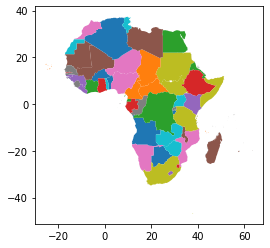

In [4]:
gdf.plot(column='name')

### Analysis parameters

In the validation process, water present for more than 60% of the time was considered ephemeral or permanent.

In [5]:
# Set the two years you want to compare
past_year = '2014'
current_year = '2020'

# Set the threshold of water we want to consider water
threshold = 0.6

In [6]:
attribute_col = 'name'

products = ['wofs_ls_summary_annual']
measurements = ['frequency']
resolution = (-1000, 1000) 
output_crs = 'EPSG:6933'

In [7]:
query = {'measurements': measurements,
         'resolution': resolution,
         'output_crs': output_crs,
         }

### Define function to calculate surface water per polygon
`gdf.iloc[0:5].iterrows():` can be used to test a smaller number of polygons first.

Arguments:
* `gdf` the geodataframe of the country boundary shapefile
* `year` the designated year to investigate
* `threshold` what frequency (0-1) is considered "water"

*If you want to threshold water between two points, you will have to modify the function*

In [8]:
def water_pixels_per_polygon(gdf, year, threshold):
    num_pixels = {}
    
    # A progress indicator
    i = 0

    # Loop through polygons in geodataframe and extract satellite data
    for index, row in gdf.iterrows():

        print(" Feature {:02}/{:02}\r".format(i + 1, len(gdf)),
                      end='')

        # Get the geometry
        geom = geometry.Geometry(row.geometry.__geo_interface__,
                                 geometry.CRS(f'EPSG:{gdf.crs.to_epsg()}'))

        # Update dc query with geometry      
        query.update({'geopolygon': geom}) 

        # Load landsat (hide print statements)
        with HiddenPrints():
            ds = dc.load(product=products, 
                         time= year,
                         group_by='solar_day',
                         **query)

        # Generate a polygon mask to keep only data within the polygon
        with HiddenPrints():
            mask = xr_rasterize(gdf.iloc[[index]], ds)

        # Mask dataset to set pixels outside the polygon to `NaN`
        ds = ds.where(mask)

        # Threshold WOfS frequency and append results to dictionary
        num_pixels.update({str(row[attribute_col]) : int(ds.frequency.where(ds.frequency > threshold, drop=True).count().values)})

        # Update counter
        i += 1
        
    return num_pixels

We run this function twice; once each for each of the years to be compared. This process can take a while and is sped up with a higher-core instance.

In [9]:
num_pixels_current = water_pixels_per_polygon(gdf, current_year, threshold)

In [10]:
num_pixels_current

{'Sudan': 2804,
 'Angola': 741,
 'Benin': 132,
 'Botswana': 96,
 'Burkina Faso': 501,
 'Cameroon': 1545,
 'Cape Verde': 99,
 'Central African Republic': 131,
 'Chad': 1715,
 'Comoros': 1,
 'Republic of the Congo': 815,
 "Cote d'Ivoire": 1559,
 'Democratic Republic of the Congo': 29902,
 'Djibouti': 119,
 'South Sudan': 386,
 'Equatorial Guinea': 67,
 'Eritrea': 354,
 'Ethiopia': 7222,
 'Gabon': 1055,
 'Gambia': 651,
 'Ghana': 6436,
 'Guinea-Bissau': 149,
 'Guinea': 118,
 'Kenya': 11643,
 'Lesotho': 0,
 'Liberia': 198,
 'Madagascar': 1349,
 'Malawi': 23253,
 'Mali': 1060,
 'Mauritania': 303,
 'Mauritius': 6,
 'Mozambique': 10256,
 'Namibia': 175,
 'Niger': 343,
 'Nigeria': 3960,
 'Senegal': 1216,
 'Seychelles': 39,
 'Sierra Leone': 159,
 'Somalia': 405,
 'South Africa': 1751,
 'Burundi': 1874,
 'Eswatini': 19,
 'Togo': 114,
 'Uganda': 35262,
 'Tanzania': 60052,
 'Zambia': 11370,
 'Zimbabwe': 2639,
 'Algeria': 270,
 'Libya': 344,
 'Morocco': 271,
 'Rwanda': 1211,
 'Sao Tome and Principe'

In [11]:
num_pixels_past = water_pixels_per_polygon(gdf, past_year, threshold)

### Append the new data and export dataframe

In [12]:
pdpixel_past = pd.Series(num_pixels_past)
pdpixel_current = pd.Series(num_pixels_current)

# Calculate the difference between the current and past years
pdpixel_diff = pdpixel_current - pdpixel_past

In [13]:
# Add to the geodataframe
gdf = gdf.assign(px_past=pdpixel_past.values)
gdf = gdf.assign(px_current=pdpixel_current.values)
gdf = gdf.assign(px_diff=pdpixel_diff.values)

In [15]:
# Calculate percentage change (pc_change)
pc_change = (gdf.px_diff/gdf.px_past*100).fillna(0)

# Add to the geodataframe
gdf = gdf.assign(pc_change=pc_change.values)

### Export new shapefile with % change data

In [16]:
gdf.to_file("wofs_pc_change_"+past_year+"_"+current_year+".shp")

## 2 - Plot WOfS with country boundaries

If you have successfully exported the previous shapefile but started a new instance, there is no need to re-process the data. It can be read in from the shapefile by uncommenting and running the code below. Be sure the vector file path is to the correct shapefile title.

In [17]:
# vector_file = "wofs_pc_change_2014_2020.shp"
# gdf = gpd.read_file(vector_file)

In [18]:
gdf.head()

,name,geometry,px_past,px_current,px_diff,pc_change
0,Sudan,"MULTIPOLYGON (((38.58148 18.02542, 38.58203 18...",2509,2804,295,11.757672
1,Angola,"MULTIPOLYGON (((11.79481 -16.81925, 11.79375 -...",496,741,245,49.395161
2,Benin,"MULTIPOLYGON (((1.86343 6.28872, 1.86292 6.288...",115,132,17,14.782609
3,Botswana,"POLYGON ((25.17447 -17.77881, 25.18476 -17.783...",1188,96,-1092,-91.919192
4,Burkina Faso,"POLYGON ((-0.45567 15.08082, -0.45411 15.07937...",320,501,181,56.562500


### Customise the plot

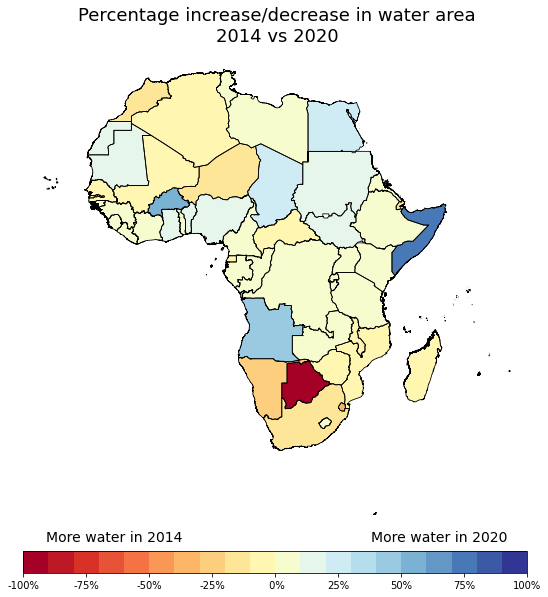

In [19]:
# Define plot and colourbar axes
fig, ax = plt.subplots(1,1, figsize=(10,10))
fig.subplots_adjust(bottom=0.2)
cax = fig.add_axes([0.16, 0.15, 0.70, 0.03])

# Define colour map
cmap = mpl.cm.RdYlBu
bounds = list(range(-100, 101, 10))
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)#, extend='both')
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')

# Define colourbar labelling
cbar.set_ticks(list(range(-100, 101, 25)))
cbar.set_ticklabels(list('{:2}%'.format(i) for i in (list(range(-100, 101, 25)))))
# cbar.set_label("% change", fontsize='14')

# Turn off lon-lat ticks and labels
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

# Remove frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# plot 'pc_change' and 'geometry' boundary lines
gdf.plot('pc_change', ax=ax, cmap=cmap, vmin=-100, vmax=100, norm=norm)
gdf.geometry.plot(ax=ax, linewidth=0.8, edgecolor='black', facecolor="none")

# Additional text boxes
ax.text(-25, -52, s="More water in 2014", color='black', fontsize='14')
ax.text(37, -52, s="More water in 2020", color='black', fontsize='14')

# Plot title
ax.set_title("Percentage increase/decrease in water area\n2014 vs 2020", fontsize='18')

# Export figure
fig.savefig('wofs_pc_change_2014_vs_2020.png', bbox_inches='tight', dpi=200, facecolor="white")

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).

**Compatible datacube version:**

In [20]:
print(datacube.__version__)

1.8.6


**Last Tested:**

In [21]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2022-01-07'